In [288]:
import os
import h5py

import socket
import struct
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader

import time

from tqdm import tqdm



import numpy as np
import copy

In [289]:
import torch
import torchvision
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from torch.utils.data.sampler import SubsetRandomSampler
%matplotlib inline

# Use a white background for matplotlib figures
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

client side


In [290]:
# keep the path same, just create a folder named cifar in your drive
root_path = './cifar'

In [291]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = "cpu"
print(device)

cuda:0


In [292]:

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))])

In [293]:

trainset1 = torchvision.datasets.CIFAR10(root=root_path, download=True, transform=transform)


Files already downloaded and verified


In [294]:
len(trainset1)

50000

In [295]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


In [296]:
import matplotlib.pyplot as plt


def show_image(img, label):
    #print("Label=", trainset1.classes[label], "(" + str(label)  + ")")
    plt.imshow(img.permute(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


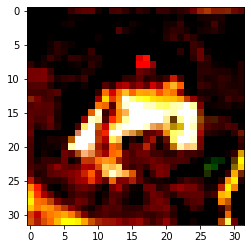

In [297]:
image,label = trainset1[0]
show_image(image, label)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


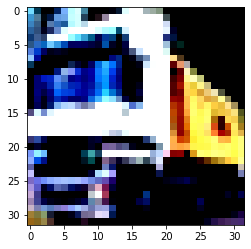

In [298]:
image,label = trainset1[1]
show_image(image, label)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


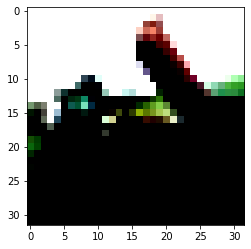

In [299]:
image,label = trainset1[2]
show_image(image, label)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


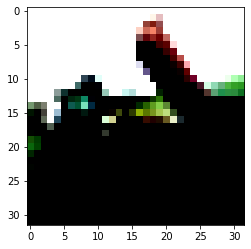

In [300]:
image,label = trainset1[2]
show_image(image, label)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


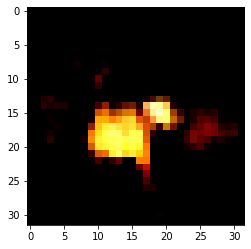

In [301]:
image,label = trainset1[3]
show_image(image, label)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


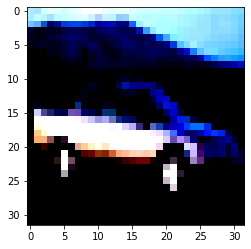

In [302]:
image,label = trainset1[4]
show_image(image, label)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


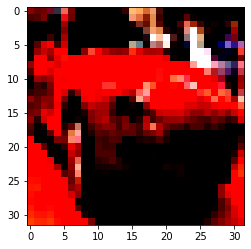

In [303]:
image,label = trainset1[5]
show_image(image, label)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


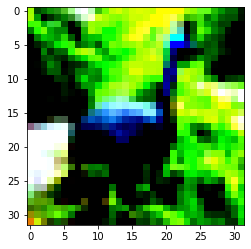

In [304]:
image,label = trainset1[6]
show_image(image, label)

# Define below number of users/clients

In [305]:
users = 5 # clients

In [306]:
trainset1_len = 50000

In [307]:
idxs = np.random.permutation(trainset1_len)
idxs

array([22227, 23462, 16621, ...,  5993, 21351,  3470])

In [308]:
train_indices = idxs
train_indices

array([22227, 23462, 16621, ...,  5993, 21351,  3470])

In [309]:
indices_per_client = int (len(train_indices)/users)

print(indices_per_client)

10000


# trainset2 which has non poisoned data

In [310]:
trainset2 = torchvision.datasets.CIFAR10(root=root_path, download=False, transform=transform)

# TestSet 

In [311]:
testset = torchvision.datasets.CIFAR10 (root=root_path, train=False, download=True, transform=transform)

Files already downloaded and verified


# doing label flipping

In [312]:


# for i in range(len(trainset1)):
#     if (trainset2.targets[i] == 6):
#         trainset2.targets[i] = 8
#     if (trainset2.targets[i] == 2):
#         trainset2.targets[i] = 9

In [313]:
len(testset)

10000

In [314]:
idxs = np.random.permutation(10000)
idxs

array([2964, 8832, 3462, ..., 7984, 6532, 3611])

In [315]:
val_indices = idxs
val_indices 

array([2964, 8832, 3462, ..., 7984, 6532, 3611])

In [316]:
#experimenting 

users = 5



batch_size = 100

train_loaders2 = [] 

train_trainset2=[]

train_loaders1 = []

train_trainset1 = []


for i in range(users):
  start= indices_per_client*i
  end= indices_per_client * (i+1)
  
  #print((train_indices[start:end]))


  train_trainset1.append(list(train_indices[start:end]))

  train_trainset2.append(list(train_indices[start:end]))

  #print(len(train_dataset))

  train_sampler = SubsetRandomSampler(train_indices[start : end])
  # train_loaders= DataLoader(dataset, batch_size, sampler= train_sampler) 

  #####*********************************************************************################
  ##### IMPORTANT : HERE BELOW CHANGE IF CONDITION TO SELECT NO OF POISONED CLIETNS ########
  #####*********************************************************************################

  if i < 0 :
    print("poisoned: ", i)
    train_loaders1.append(DataLoader(trainset1, batch_size=batch_size,sampler=train_sampler)) # client training on poisoned data
  else:
    train_loaders1.append(DataLoader(trainset2, batch_size=batch_size,sampler=train_sampler)) # rest training on normal data
    print("non-poisoned: ", i)



  train_loaders2.append(DataLoader(trainset2, batch_size=batch_size,sampler=train_sampler))

  





val_sampler = SubsetRandomSampler(val_indices)



test_loader = DataLoader(testset, batch_size=1, sampler=val_sampler) 
# 



non-poisoned:  0
non-poisoned:  1
non-poisoned:  2
non-poisoned:  3
non-poisoned:  4


In [317]:
print(len(train_trainset1))

5


In [318]:
len(train_loaders1)

5

In [319]:
from torch.autograd import Variable
import torch.nn.init as init

def _weights_init(m):
    classname = m.__class__.__name__
    #print(classname)
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight)

class LambdaLayer(nn.Module):
    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd

    def forward(self, x):
        return self.lambd(x)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, option='A'):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            if option == 'A':
                """
                For CIFAR10 ResNet paper uses option A.
                """
                self.shortcut = LambdaLayer(lambda x:
                                            F.pad(x[:, :, ::2, ::2], (0, 0, 0, 0, planes//4, planes//4), "constant", 0))
            elif option == 'B':
                self.shortcut = nn.Sequential(
                     nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                     nn.BatchNorm2d(self.expansion * planes)
                )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 16

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        self.linear = nn.Linear(64, num_classes)

        self.apply(_weights_init)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, out.size()[3])
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def resnet20():
    return ResNet(BasicBlock, [3, 3, 3])

In [320]:
net_glob = resnet20()
net_glob.to(device)


ResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=

In [321]:

lr = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net_glob.parameters(), lr=lr, momentum=0.9)


In [322]:
local_epochs = 1

In [323]:
def FedAvg(w):
    w_avg = copy.deepcopy(w[0])
    for k in w_avg.keys():
        for i in range(1, len(w)):
            w_avg[k] += w[i][k]
        w_avg[k] = torch.div(w_avg[k], len(w))
    return w_avg

In [324]:
num_users = 1

frac = 1 # this tells the percentage of clients chosen for each global round. 1=100%(all the clinets are chosen),0.5(only half the clients are chosen)

In [325]:
# # FGSM attack code
# def fgsm_attack(image, epsilon, data_grad):
#     # Collect the element-wise sign of the data gradient
#     sign_data_grad = data_grad.sign()
#     # Create the perturbed image by adjusting each pixel of the input image
#     perturbed_image = image + epsilon*sign_data_grad
#     # Adding clipping to maintain [0,1] range
#     perturbed_image = torch.clamp(perturbed_image, 0, 1)
#     # Return the perturbed image
#     return perturbed_image

In [326]:
# def cw_l2_attack(model, images, labels, targeted=False, c=1e-4, kappa=0, max_iter=1000, learning_rate=0.01, device = device) :

#     images = images.to(device)     
#     labels = labels.to(device)

#     # Define f-function
#     def f(x) :
#         #model = model.to(device)
#         outputs = model(x)
#         outputs = outputs.to(device)
#         one_hot_labels = torch.eye(len(outputs[0]))[labels.to(device)]

#         i, _ = torch.max((1-one_hot_labels)*outputs, dim=1)
#         j = torch.masked_select(outputs, one_hot_labels.byte())
        
#         # If targeted, optimize for making the other class most likely 
#         if targeted :
#             return torch.clamp(i-j, min=-kappa)
        
#         # If untargeted, optimize for making the other class most likely 
#         else :
#             return torch.clamp(j-i, min=-kappa)
    
#     w = torch.zeros_like(images, requires_grad=True).to(device)

#     optimizer = optim.Adam([w], lr=learning_rate)

#     prev = 1e10
    
#     for step in range(max_iter) :

#         a = 1/2*(nn.Tanh()(w) + 1)

#         loss1 = nn.MSELoss(reduction='sum')(a, images)
#         loss2 = torch.sum(c*f(a))

#         cost = loss1 + loss2

#         optimizer.zero_grad()
#         cost.backward()
#         optimizer.step()

#         # Early Stop when loss does not converge.
#         if step % (max_iter//10) == 0 :
#             if cost > prev :
#                 print('Attack Stopped due to CONVERGENCE....')
#                 return a
#             prev = cost
        
#         print('- Learning Progress : %2.2f %%        ' %((step+1)/max_iter*100), end='\r')

#     attack_images = 1/2*(nn.Tanh()(w) + 1)

#     return attack_images


In [327]:
import copy
import numpy as np
import torch
from torch.autograd import grad

def deepfool(image, net, device, num_classes=10, overshoot=0.02, max_iter=50):
    """
    A function to generate adversarial examples using the deepfool algorithm.

    Args:
    image (torch.Tensor): The input image tensor of shape (1, channels, height, width).
    net (torch.nn.Module): The neural network to be fooled by the adversarial example.
    device (torch.device): The device to run the computation on (CPU or GPU).
    num_classes (int): The number of classes to test against (default=10).
    overshoot (float): Used as a termination criterion to prevent vanishing updates (default=0.02).
    max_iter (int): The maximum number of iterations for the deepfool algorithm (default=50).

    Returns:
    r_tot (torch.Tensor): The minimal perturbation that fools the classifier.
    loop_i (int): The number of iterations required to generate the adversarial example.
    label_orig (int): The original label of the input image.
    label_pert (int): The predicted label of the adversarial example.
    pert_image (torch.Tensor): The adversarial example tensor of shape (1, channels, height, width).
    """
    image = image.float().to(device)
    print(image.size())
    f_image = net(image).data.cpu().numpy().flatten()
    #print(f_image.size())
    I = np.argsort(f_image)[::-1][:10]
    print("I", I)
    label_orig = int(I[0])
    print("2",label_orig)

    input_shape = image.cpu().numpy().shape
    pert_image = copy.deepcopy(image)
    w = np.zeros(input_shape)
    r_tot = np.zeros(input_shape)

    loop_i = 0
    #pert_image = pert_image.reshape(1, input_shape[0], input_shape[1], input_shape[2])
    pert_image = pert_image.reshape(input_shape[0], input_shape[1], input_shape[2], input_shape[3])
    print(pert_image.size())
    #pert_image = pert_image.reshape(1, input_shape[2], input_shape[3])
    x = torch.tensor(pert_image, requires_grad=True, device=device)
    fs = net(x)
    
    fs_list = [fs[0, I[k]] for k in range(num_classes)]
    k_i = label_orig

    while k_i == label_orig and loop_i < max_iter:
        pert = np.inf
        grad_orig = grad(fs[0, I[0]], x, create_graph=True)[0].cpu().numpy()

        for k in range(1, num_classes):
            cur_grad = grad(fs[0, I[k]], x, create_graph=True)[0].cpu().numpy()

            w_k = cur_grad - grad_orig
            f_k = (fs[0, I[k]] - fs[0, I[0]]).data.cpu().numpy()

            pert_k = abs(f_k)/np.linalg.norm(w_k.flatten())

            if pert_k < pert:
                pert = pert_k
                w = w_k

        r_i = pert * w / np.linalg.norm(w)
        r_tot = np.float32(r_tot + r_i)

        pert_image = image + (1+overshoot)*torch.from_numpy(r_tot).to(device)

        x = torch.tensor(pert_image, requires_grad=True, device=device)
        fs = net(x)
        k_i = np.argmax(fs.data.cpu().numpy().flatten())

        loop_i += 1

    r_tot = (1+overshoot)*r_tot

    label_pert = k_i

    return r_tot, loop_i, label_orig, label_pert, pert_image


In [328]:



import numpy as np
from torch.autograd import Variable
import torch as torch
import copy
#from torch.autograd.gradcheck import zero_gradients
#from torch.autograd.grad_mode import zero_gradients
def zero_gradients(x):
    if x.grad is not None:
        x.grad.detach_()
        x.grad.zero_()

def deepfool(image, net, device, num_classes=10, overshoot=0.02, max_iter=50):

    """
       :param image: 输入图像：1x1x28x28
       :param net: network
       :device: cuda or cpu
       :param num_classes: num_classes (limits the number of classes to test against, by default = 10)
       :param overshoot: used as a termination criterion to prevent vanishing updates (default = 0.02).
       :param max_iter: maximum number of iterations for deepfool (default = 50)
       :return: minimal perturbation that fools the classifier, number of iterations that it required, new estimated_label and perturbed image
    """
    # image = image.reshape(1, 1, 28, 28)
    # image = torch.tensor(image)
    image = image.float().to(device)

    f_image = net(image).data.cpu().numpy().flatten()
    # argsort()为从小到大排序，并依此返回索引
    # [::-1]表示反转
    I = (np.array(f_image)).flatten().argsort()[::-1]
    # I为前10个标签信息
    I = I[0:num_classes]
    label = I[0]

    # 扰动初始化
    input_shape = image.cpu().numpy().shape
    pert_image = copy.deepcopy(image)
    w = np.zeros(input_shape)
    r_tot = np.zeros(input_shape)

    loop_i = 0

    #pert_image = pert_image.reshape(1, 32, 32)
    pert_image = pert_image.reshape(input_shape[1], input_shape[2], input_shape[3])
    #pert_image = pert_image.reshape(input_shape[0], input_shape[1], input_shape[2], input_shape[3])
    x = Variable(pert_image[None, :], requires_grad=True)
    #print(x.size())
    fs = net(x)
    fs_list = [fs[0,I[k]] for k in range(num_classes)]
    k_i = label

    # 当k_i！=label时，即对抗样本越过了边界，结束循环
    while k_i == label and loop_i < max_iter:
        """"
        通过内部的for循环可以获得x到各分类边界的距离；
        在外部的while循环中，利用所有边界距离中的最小值对x进行更新。
        重复这一过程，直到的分类标签发生变化。
        """
    # 初始梯度
        pert = np.inf
        fs[0, I[0]].backward(retain_graph=True)
        grad_orig = x.grad.data.cpu().numpy().copy()

        for k in range(1, num_classes):
            zero_gradients(x)
            # 第k个分类器，对x的梯度，即wk
            fs[0, I[k]].backward(retain_graph=True)
            cur_grad = x.grad.data.cpu().numpy().copy()

            # set new w_k and new f_k
            w_k = cur_grad - grad_orig          # wk
            f_k = (fs[0, I[k]] - fs[0, I[0]]).data.cpu().numpy()  # fk

            pert_k = abs(f_k)/np.linalg.norm(w_k.flatten())  # l'

            # determine which w_k to use
            # 取最短距离
            if pert_k < pert:
                pert = pert_k
                w = w_k

        # 扰动r_i=最短距离pert*单位法向量
        r_i =  (pert+1e-4) * w / np.linalg.norm(w)
        r_tot = np.float32(r_tot + r_i)

        # 加上扰动时，为(1+overshoot)
        pert_image = image + (1+overshoot)*torch.from_numpy(r_tot).to(device)

        x = Variable(pert_image, requires_grad=True)
        fs = net(x)
        k_i = np.argmax(fs.data.cpu().numpy().flatten())

        loop_i += 1

    r_tot = (1+overshoot)*r_tot

    return r_tot, loop_i, label, k_i, pert_image

In [329]:
# import copy
# import numpy as np
# import torch
# from torch.autograd import Variable
# from torch.optim import zero_grad

# def deepfool(image, net, device, num_classes=10, overshoot=0.02, max_iter=50):
#     """
#     A function to generate adversarial examples using the deepfool algorithm.

#     Args:
#     image (torch.Tensor): The input image tensor of shape (1, channels, height, width).
#     net (torch.nn.Module): The neural network to be fooled by the adversarial example.
#     device (torch.device): The device to run the computation on (CPU or GPU).
#     num_classes (int): The number of classes to test against (default=10).
#     overshoot (float): Used as a termination criterion to prevent vanishing updates (default=0.02).
#     max_iter (int): The maximum number of iterations for the deepfool algorithm (default=50).

#     Returns:
#     r_tot (torch.Tensor): The minimal perturbation that fools the classifier.
#     loop_i (int): The number of iterations required to generate the adversarial example.
#     label_orig (int): The original label of the input image.
#     label_pert (int): The predicted label of the adversarial example.
#     pert_image (torch.Tensor): The adversarial example tensor of shape (1, channels, height, width).
#     """
#     image = image.float().to(device)

#     f_image = net(image).data.cpu().numpy().flatten()
#     I = np.argsort(f_image)[::-1][:num_classes]
#     label_orig = int(I[0])

#     input_shape = image.cpu().numpy().shape
#     pert_image = copy.deepcopy(image)
#     w = np.zeros(input_shape)
#     r_tot = np.zeros(input_shape)

#     loop_i = 0

#     pert_image = pert_image.reshape(1, input_shape[1], input_shape[2])
#     x = Variable(pert_image[None, :], requires_grad=True)
#     fs = net(x)
#     fs_list = [fs[0, I[k]] for k in range(num_classes)]
#     k_i = label_orig

#     while k_i == label_orig and loop_i < max_iter:
#         pert = np.inf
#         fs[0, I[0]].backward(retain_graph=True)
#         grad_orig = x.grad.data.cpu().numpy().copy()

#         for k in range(1, num_classes):
#             zero_grad(x)
#             fs[0, I[k]].backward(retain_graph=True)
#             cur_grad = x.grad.data.cpu().numpy().copy()

#             w_k = cur_grad - grad_orig
#             f_k = (fs[0, I[k]] - fs[0, I[0]]).data.cpu().numpy()

#             pert_k = abs(f_k)/np.linalg.norm(w_k.flatten())

#             if pert_k < pert:
#                 pert = pert_k
#                 w = w_k

#         r_i = pert * w / np.linalg.norm(w)
#         r_tot = np.float32(r_tot + r_i)

#         pert_image = image + (1+overshoot)*torch.from_numpy(r_tot).to(device)

#         x = Variable(pert_image, requires_grad=True)
#         fs = net(x)
#         k_i = np.argmax(fs.data.cpu().numpy().flatten())

#         loop_i += 1

#     r_tot = (1+overshoot)*r_tot

#     label_pert = k_i

#     return r_tot, loop_i, label_orig, label_pert, pert_image


In [330]:
def test(net, test_loader, criterion, device, max_iter=50, eps=0.02):
    net.eval()  # set the model to evaluation mode
    test_loss = 0.0
    correct = 0
    total = 0
    per_num = 0  # number of adversarial examples generated

    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = net(data)
        _, predicted = torch.max(output.data, 1)
        if torch.all(predicted != target):
            continue  # skip correctly classified examples

        # generate adversarial example using DeepFool attack
        r_tot, loop_i, label_orig, label_pert, pert_image = deepfool(data, net, device= device,)
        if label_pert == label_orig:
            correct += 1
        else:
            per_num += 1

        # compute loss and accuracy
        with torch.no_grad():
            #output = net(pert_image.unsqueeze(0))
            output = net(pert_image)
            loss = criterion(output, target)

        test_loss += loss.item()
        total += 1

    test_loss /= total
    accuracy = 100.0 * correct / total
    print('Test loss: {:.4f}, Accuracy: {:.2f}%, Number of adversarial examples generated: {}'.format(
        test_loss, accuracy, per_num))

In [331]:
# # def fgsm_attack(model, loss, images, labels, eps) :
    
# #     images = images.to(device)
# #     labels = labels.to(device)
# #     images.requires_grad = True
           
# #     outputs = model(images)
    
# #     model.zero_grad()
# #     cost = criterion(outputs, labels)
# #     cost.backward()
    
# #     attack_images = images + eps*images.grad.sign()
# #     attack_images = torch.clamp(attack_images, 0, 1)
# def output(sample, net):
#     sample = sample.float().to(device)
#     output = net(sample).cpu()
#     _, pre = torch.max(output.data, 1)
#     return pre   
# def test(net, test_loader, criterion, device):
#     net.eval()  # set the model to evaluation mode
#     test_loss = 0.0
#     correct = 0
#     total = 0
#     false = 0
#     per_num = 0
#     per = np.zeros((10000, 28, 28))
#     loop = []
#     per_label = []
#     per_image = torch.zeros((10000, 28, 28))

#     for data, target in test_loader:
#         data, target = data.to(device), target.to(device)
#         with torch.no_grad():
#           output = net(data)
#         predicted = torch.argmax(output, dim=1)

#         if torch.all(predicted == target):
#             r_tot, loop_i, label_orig, label_pert, pert_image = deepfool(data, net, device)
#             if label_pert == label_orig:
#                 correct += 1
#             else:
#                 per[per_num] = r_tot.reshape(28, 28)                  
#                 loop = np.append(loop, loop_i)                    
#                 per_label = np.append(per_label, label_pert)      
#                 per_image[per_num] = pert_image.reshape(28, 28)  
#                 per_num += 1
#         else:
#             false += 1

#         # Calculate the loss
#         with torch.no_grad():
#             output = net(data)
#             loss = criterion(output, target)
#             test_loss += loss.item()

#         # Compute accuracy
#         _, predicted = torch.max(output.data, 1)
#         total += target.size(0)
#         correct += (predicted == target).sum().item()

#         if total % 1000 == 0:
#             print('Accuracy: {:.2f}%'.format(100 * correct / total))
        
#     test_loss /= len(test_loader)
#     accuracy = 100.0 * correct / total
#     print('Test set: Average loss: {:.4f}, Accuracy: {:.2f}%'.format(test_loss, accuracy))
#     print('Classification error rate: {:.2f}%'.format(100 * (1 - correct / total)))
#     print('Number of adversarial examples generated: {}'.format(per_num))



In [332]:
# def test(net, test_loader, criterion, device, max_iter=50, eps=0.02):
#     net.eval()  # set the model to evaluation mode
#     test_loss = 0.0
#     correct = 0
#     total = 0
#     per_num = 0  # number of adversarial examples generated

#     for data, target in test_loader:
#         data, target = data.to(device), target.to(device)
#         output = net(data)
#         _, predicted = torch.max(output.data, 1)
#         if torch.all(predicted != target):
#             continue  # skip correctly classified examples

#         # generate adversarial example using DeepFool attack
#         r_tot, loop_i, label_orig, label_pert, pert_image = deepfool(data, net, device, max_iter, eps)
#         if label_pert == label_orig:
#             correct += 1
#         else:
#             per_num += 1

#         # compute loss and accuracy
#         with torch.no_grad():
#             output = net(pert_image.unsqueeze(0))
#             loss = criterion(output, target)

#         test_loss += loss.item()
#         total += 1

#     test_loss /= total
#     accuracy = 100.0 * correct / total
#     print('Test loss: {:.4f}, Accuracy: {:.2f}%, Number of adversarial examples generated: {}'.format(
#         test_loss, accuracy, per_num))


In [333]:
def display_images(image):
  #_, label, confidence = get_imagenet_label(pretrained_model.predict(image))
  plt.figure()
  #image = image.T
  fig, axarr = plt.subplots(2, 2)
  for i in range(2):
      for j in range(2):
          axarr[i, j].imshow(image[i*2+j].permute(1, 2, 0))
  plt.show()

In [ ]:
net_glob.train()
# copy weights
w_glob = net_glob.state_dict()

loss_train_collect = []
acc_train_collect = []
loss_test_collect = []
acc_test_collect = []



for iter in range(5):
    w_locals, loss_locals_train, acc_locals_train, loss_locals_test, acc_locals_test = [], [], [], [], []
    m = max(int(frac * num_users), 1)
    idxs_users = np.random.choice(range(num_users), m, replace = False)
    

    global_weights = copy.deepcopy(net_glob.state_dict())
   
    # Training/Testing simulation
    for idx in idxs_users: # each client
        
        net_glob.load_state_dict(global_weights)
        # client training local epochs  
        for local_epoch in range(local_epochs):

          for i, data in enumerate(tqdm(train_loaders1[idx], ncols=100, desc='Round'+str(iter+1)+': User'+str(idx)+'_'+str(local_epoch+1))):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            #display_images(inputs)
            inputs = inputs.to(device)
            labels = labels.clone().detach().long().to(device)
            #data.requires_grad = True

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net_glob(inputs)
            loss = criterion(outputs, labels)
            #net_glob.zero_grad()
            loss.backward()
            #data_grad = data.grad.data
            #perturbed_data = fgsm_attack(inputs, 0.3, data_grad)
            #output = net_glob(perturbed_data)
            optimizer.step()
          
        w = copy.deepcopy(net_glob.state_dict())
        w_locals.append(copy.deepcopy(w))
      
      
    w_glob = FedAvg(w_locals)
    # update global model --- copy weight to net_glob -- distributed the model to all users
    net_glob.load_state_dict(w_glob)

    # train acc
    with torch.no_grad():
        corr_num = 0
        total_num = 0
        train_loss = 0.0
        for idx in idxs_users:
          for j, trn in enumerate(train_loaders2[idx]):
            trn_x, trn_label = trn
            trn_x = trn_x.to(device)
            trn_label = trn_label.clone().detach().long().to(device)

            trn_output = net_glob(trn_x)
            loss = criterion(trn_output, trn_label)
            train_loss += loss.item()
            model_label = trn_output.argmax(dim=1)
            corr = trn_label[trn_label == model_label].size(0)
            corr_num += corr
            total_num += trn_label.size(0)
          print("client:{} train_acc: {:.2f}%, train_loss: {:.4f}".format(idx, corr_num / total_num * 100, train_loss / len(train_loaders2)))

    # Assuming you have already defined your neural network model, test dataset loader, loss criterion, and device
    #epsilon = 0.2  # choose a value for epsilon
    test(net=net_glob, test_loader=test_loader, criterion=criterion, device = device)
#     with torch.no_grad():
#         corr_num = 0
#         total_num = 0
#         val_loss = 0.0
#         for j, val in enumerate(test_loader):
#             val_x, val_label = val
#             val_x = val_x.to(device)
#             data = val_x
            
#             data.requires_grad = True
#             #val_x = fgsm_attack(net_glob, loss, val_x, val_label, 0.3).to(device)
#             val_label = val_label.clone().detach().long().to(device)
#             val_output = net_glob(data)
            
#             loss = criterion(val_output, val_label)
#             net_glob.zero_grad()
#             loss.backward()
#             data_grad = data.grad.data
#             perturbed_data = fgsm_attack(data, 0.3, data_grad)
#             output = net_glob(perturbed_data)
#             val_loss += loss.item()
#             model_label = val_output.argmax(dim=1)
#             corr = val_label[val_label == model_label].size(0)
#             corr_num += corr
#             total_num += val_label.size(0)
#             accuracy = corr_num / total_num * 100
#             test_loss = val_loss / len(test_loader)
#         print("test_acc: {:.2f}%, test_loss: {:.4f}".format( accuracy, test_loss))
    
#     # prepare to count predictions for each class
#     correct_pred = {classname: 0 for classname in classes}
#     total_pred = {classname: 0 for classname in classes}

#     # again no gradients needed
#     with torch.no_grad():
#         for data in test_loader:
#             images, labels = data
#             outputs = net_glob(images)
#             _, predictions = torch.max(outputs, 1)
#             # collect the correct predictions for each class
#             for label, prediction in zip(labels, predictions):
#                 if label == prediction:
#                     correct_pred[classes[label]] += 1
#                 total_pred[classes[label]] += 1


#     # print accuracy for each class
#     for classname, correct_count in correct_pred.items():
#         accuracy = 100 * float(correct_count) / total_pred[classname]
#         print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
#                                                       accuracy))



Round1: User0_1: 100%|████████████████████████████████████████████| 100/100 [00:07<00:00, 13.76it/s]


client:0 train_acc: 27.86%, train_loss: 38.4794


In [ ]:
test(net=net_glob, test_loader=test_loader, criterion=criterion, device = device)